Source: [part 5](https://github.com/bentrevett/pytorch-seq2seq/blob/master/5%20-%20Convolutional%20Sequence%20to%20Sequence%20Learning.ipynb)

In [1]:
import os
from IPython.display import Image

pth = os.getcwd()
pth


'/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/NLPstudy'

# 5 - Convolutional Sequence to Sequence Learning

In this notebook we'll be implementing the [Convolutional Sequence to Sequence Learning](https://arxiv.org/abs/1705.03122) model. 

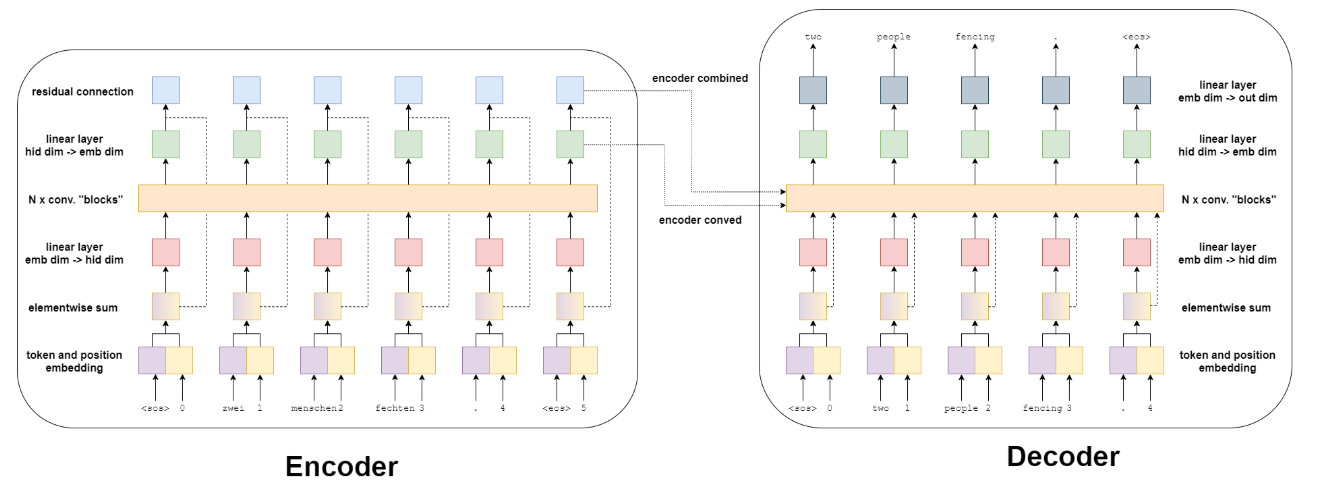

In [2]:
Image(filename = pth + "/images/5_1_cnnseq2seq.png")

## Introduction

This model is drastically different to the previous models used in these tutorials. There is are no recurrent components used at all. Instead it makes use of convolutional layers, typically used for image processing. 

In short, a convolutional layer uses *filters*. These filters have a *width* (and also a *height* in images, but usually not text). If a filter has a width of 3, then it can see 3 consecutive tokens. Each convolutional layer has many of these filters (1024 in this tutorial). Each filter will slide across the sequence, from beginning to the end, looking at all 3 consectuive tokens at a time. The idea is that each of these 1024 filters will learn to extract a different feature from the text. The result of this feature extraction will then be used by the model - potentially as input to another convolutional layer. This can then all be used to extract features from the source sentence to translate it into the target language.


## Preparing the Data

First, let's import all the required modules and set the random seeds for reproducability.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.tensor as Tensor

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns

import spacy

import random
import math
import time

In [3]:
# Set random seeds for reproducibility

SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### 1. Create the Tokenizers

Next, we'll create the tokenizers. A tokenizer is used to turn a string containing a sentence into a list of individual tokens that make up that string, e.g. "good morning!" becomes ["good", "morning", "!"].

spaCy has model for each language ("de" for German and "en" for English) which need to be loaded so we can access the tokenizer of each model.

In [4]:
# Download the spacy models via command line:
# conda activate pynlp_env
# cd /development/.../NLPStudy/data
# python -m spacy download en
# python -m spacy download de

# Then load the models
#spacyDE = spacy.load('de')

spacyEN = spacy.load('en')
spacyDE = spacy.load('de')
#spacyFR = spacy.load('fr') # french!
#spacyIT = spacy.load('it')
# site link for other language models: https://spacy.io/usage/models

### 2. Create the Tokenizer Functions

Next, we create the tokenizer functions. These can be passed to TorchText and will take in the sentence as a string and return the sentence as a list of tokens.

In [5]:
# Creating the tokenizer functions

#def tokenizeFrench(frenchText: str):
#    """
#    Tokenizes French text from a string into a list of strings (as tokens)
#    :param frenchText:
#    :return:
#    """
#    return [tok.text for tok in spacyFR.tokenizer(frenchText)]

def tokenizeGerman(germanText: str):
    """
    Tokenizes German text from a string into a list of strings (as tokens)
    :param germanText: 
    :return: 
    """
    return [tok.text for tok in spacyDE.tokenizer(germanText)]



def tokenizeEnglish(englishText: str):
    """
    Tokenizes English text from a string into a list of strings (as tokens)
    and reverses it
    
    :param englishText: 
    :return: 
    """
    return [tok.text for tok in spacyEN.tokenizer(englishText)]

We set the tokenize argument to the correct tokenization function for each, with German being the `SRC` (source) field and English being the `TRG` (target) field. The `Field` also appends the "start of sequence" and "end of sequence" tokens via the `init_token` and `eos_token` arguments, and converts all words to lowercase.

[To read more about Field's arguments](https://github.com/pytorch/text/blob/master/torchtext/data/field.py#L61)

 **Difference this time:** 
By default RNN models in PyTorch require the sequence to be a tensor of shape **(`sequenceLength`, `batchSize`)** so TorchText will, by default, return batches of tensors in the same shape. 
However in this notebook we are using CNNs which expect the batch dimension to be first. We tell TorchText to have batches be **(`batchSize`, `sequenceLength`)** by setting `batch_first = True`.  

We also append the start and end of sequence tokens as well as lowercasing all text.

In [6]:
# German = source language, English = target language

# tokenize:  The function used to tokenize strings using this field into
#             sequential examples.
# init_token: A token that will be prepended to every example using this
#             field, or None for no initial token. Default: None.
# eos_token: A token that will be appended to every example using this
#             field, or None for no end-of-sentence token. Default: None.
# lower: Whether to lowercase the text in this field. Default: False.

SRC = Field(tokenize = tokenizeGerman,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

TRG = Field(tokenize = tokenizeEnglish,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

### 3. Download the Data

Next, we download and load the train, validation and test data.

The dataset we'll be using is the [Multi30k dataset](https://github.com/multi30k/dataset)

In [7]:
# NOTE: after this, the data is stored in 
# a folder under NLPSTUDY called '.data'

trainData, validationData, testData = \
    Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))


In [8]:
# Print out examples 

# Double-checking we have the right number of examples: 
print(f"Number of training examples: {len(trainData.examples)}")
print(f"Number of validation examples: {len(validationData.examples)}")
print(f"Number of testing examples: {len(testData.examples)}")

print("\n")

# Printing out an example to make sure the source sentence is
# not reversed (if you know German); the target (english) is in proper order, though. 
print(trainData.examples[0])
print(vars(trainData.examples[0]))

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


### 4. Building the vocabulary

Next, we build the *vocabulary* for the source and target languages.

The vocabulary is used to associate each unique token (word) with an index (an integer), similar to the way a dictionary works.

This is used to build a one-hot encoding for each token (a vector of all zeros except for the position represented by the index, which is 1).

The vocabularies of the source and target languages are distinct.

- **NOTE:** Using the `min_freq` argument, we only allow tokens that appear at least 2 times to appear in our vocabulary. Tokens that appear only once are converted into an `<unk>` (unknown) token.

WARNING: It is important to note that your vocabulary should only be built from the training set and not the validation/test set. This prevents "information leakage" into your model, giving you artifically inflated validation/test scores.

In [9]:
SRC.build_vocab(trainData, min_freq=2)
TRG.build_vocab(trainData, min_freq=2)

print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7853
Unique tokens in target (en) vocabulary: 5893


### 5. (Final) Create the Iterators

The final step of preparing the data is to create the iterators. These can be iterated on to return a batch of data which will have a `src` attribute (the PyTorch tensors containing a batch of numericalized source sentences) and a `trg` attribute (the PyTorch tensors containing a batch of numericalized target sentences). Numericalized is just a fancy way of saying they have been converted from a sequence of readable tokens to a sequence of corresponding indexes, using the vocabulary.

We also need to define a `torch.device`. This is used to tell TorchText to put the tensors on the GPU or not. We use the `torch.cuda.is_available()` function, which will return `True` if a GPU is detected on our computer. We pass this `device` to the iterator.

When we get a batch of examples using an iterator we need to make sure that all of the source sentences are padded to the same length, the same with the target sentences. Luckily, TorchText iterators handle this for us!

We use a `BucketIterator` instead of the standard `Iterator` as it creates batches in such a way that it minimizes the amount of padding in both the source and target sentences. 

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [11]:
# Creating the training iterator

BATCH_SIZE = 128

trainIterator, validationIterator, testIterator = BucketIterator.splits(
    (trainData, validationData, testData),
    batch_size = BATCH_SIZE,
    #sort_within_batch = True, # new key feature
    #sort_key = lambda x: len(x.src), # new key feature
    device = device)

## Building the Model

Next up is building the model. As before, the model is made of an `Encoder` and `Decoder`. The `Encoder` *encodes* the input sentence, in the source language, into a *context vector*. The `Decoder` *decodes* the context vector to produce the output sentence in the target language.

### `Encoder`

Previous models in these tutorials had an `Encoder` that compresses an entire input sentence into a single context vector, $z$. The convolutional sequence-to-sequence model is a little different - it gets two context vectors for each token in the input sentence. So, if our input sentence had 6 tokens, we would get 12 context vectors, two for each token.

The two context vectors per token are a **conved** vector and a **combined** vector. The conved vector is the result of each token being passed through a few layers - which we will explain shortly. The combined vector comes from the sum of the convolved vector and the embedding of that token. Both of these are returned by the `Encoder` to be used by the `Decoder`.

The image below shows the result of an input sentence - *zwei menschen fechten.* - being passed through the `Encoder`.

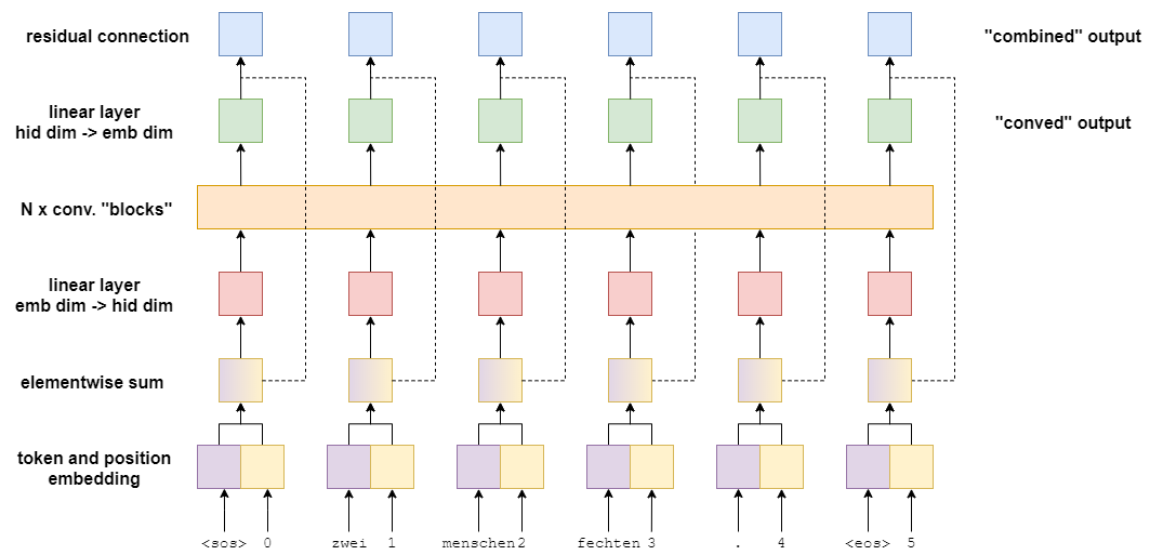

In [12]:
Image(filename = pth + "/images/5_2_encoderCNN.png")

### `Encoder` CNN Forward Pass:

1. **Token and Positional Embedding Layers:** First, the token is passed through a *token embedding layer* - which is standard for neural networks in natural language processing. However, as there are no recurrent connections in this model it has no idea about the order of the tokens within a sequence. To rectify this we have a second embedding layer, the *positional embedding layer*. This is a standard embedding layer where the input is not the token itself but the position of the token within the sequence - starting with the first token, the `<sos>` (start of sequence) token, in position 0.

2. **Embedding Vector:** Next, the `tokenEmbedding` and `posEmbedding`s are elementwise summed together to get a vector which contains information about the token and also its position with in the sequence - which we simply call the *embedding vector*, or `totalEmbedding`. 
	- This is followed by a linear layer which transforms the `totalEmbedding` into a vector with the required `hiddenDim` size.

3. [**Encoder Convolutional Blocks:**](https://hyp.is/2ioPmBUWEeqb9p8tN4Mg-Q/arxiv.org/pdf/1705.03122.pdf) The next step is to pass this hidden vector into $N$ **convolutional blocks** (defined / explained below). 
	- After passing through the convolutional blocks, the vector is then fed through another linear layer to transform it back from the `hiddenDim` size back to the `embedDim` size. This is the **`conved`** vector - and there will be one of these per token in the input sequence, `src`. [See here about size transformation](https://hyp.is/fIwMyBKNEeq9RDcdtEhPEA/arxiv.org/pdf/1705.03122.pdf)

4. [**Residual Connections:**](https://hyp.is/T6ERuBKNEeq9Q-frzC9Wjw/arxiv.org/pdf/1705.03122.pdf) Finally, the `conved` vector is elementwise summed with the embedding vector (`tokenEmbedding`) via a residual connection to get a **`combined`** vector for each token. Again, there is a combined vector for each token in the input sequence.
Formulaically, this looks like the following: we add residual connections from the input of each convolution to the output of th eblock:
$$
h_i^l = v(W^l[h_{i - k/2}^{l-1}, ..., h_{i + k/2}^{l-1}] + b_w^l) + h_i^{l-1}
$$



### [Encoder Convolutional Blocks](https://hyp.is/2ioPmBUWEeqb9p8tN4Mg-Q/arxiv.org/pdf/1705.03122.pdf)

How do these convolutional blocks work? The below image shows 2 convolutional blocks with a single filter (blue) that is sliding across the tokens within the sequence. In the actual implementation we will have 10 convolutional blocks with 1024 filters in each block.

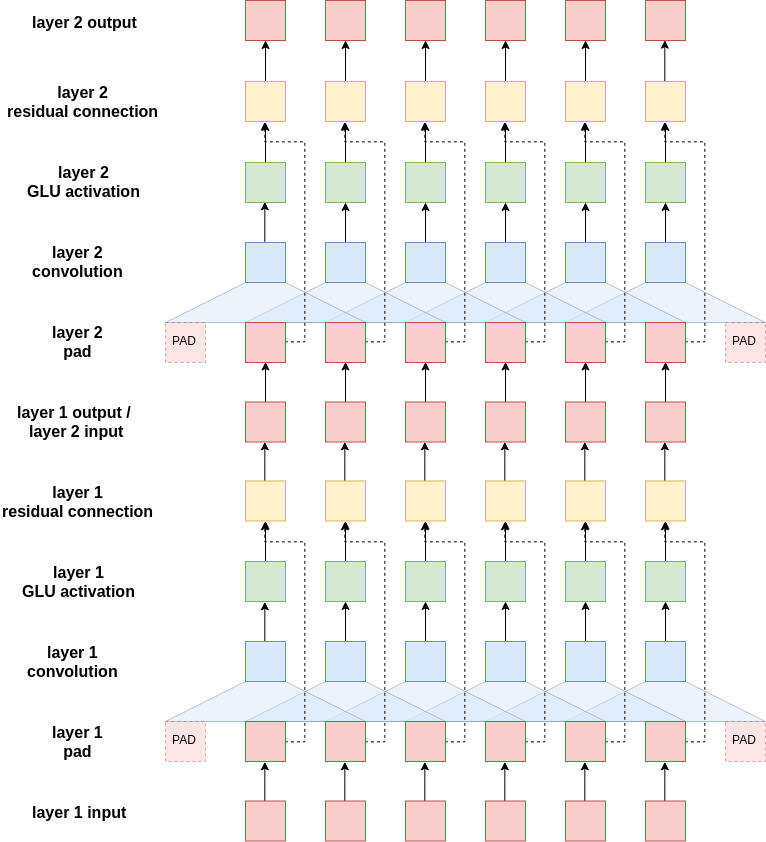

In [13]:
Image(filename = pth + "/images/5_3_CNNBlocks.png")

### [Mechanism of Encoder Convolutional Blocks:](https://hyp.is/2ioPmBUWEeqb9p8tN4Mg-Q/arxiv.org/pdf/1705.03122.pdf)

- [key feature: ](https://hyp.is/ymJLthKMEeqv03PnUdsbYw/arxiv.org/pdf/1705.03122.pdf) In the paper, each convolutional block contains a one-dimensional convolution followed by a non-linearity function. 


1. [**Padding:**](https://hyp.is/ZMpGShKNEeqXybOOcLkgmg/arxiv.org/pdf/1705.03122.pdf) First, the input sentence is padded. This is because the convolutional layers will reduce the length of the input sentence and we want the length of the sentence coming into the convolutional blocks to equal the length of it coming into the convolutional blocks. Without padding, the length of the sequence coming out of a convolutional layer will be `filterSize - 1` shorter than the sequence entering the convolutional layer. For example, if we had a filter size of 3, the sequence will be 2 elements shorter. Thus, we pad the sentence with one padding element on each side. We can calculate the amount of padding on each side by simply doing `(filterSize - 1)/2` for odd sized filters - we will not cover even sized filters in this tutorial.

2. [**Filters:**](https://hyp.is/E_AMqhKNEeqqGzePMVyaEQ/arxiv.org/pdf/1705.03122.pdf) The convolution kernels (filters) are designed so the output hidden dimension of them is twice the input hidden dimension. In computer vision terminology these hidden dimensions are called *channels* - but we will stick to calling them hidden dimensions. 
Why do we double the size of the hidden dimension leaving the convolutional filter? This is because we are using a special activation function called [**gated linear units (GLU)**](https://hyp.is/_6WLnhUHEeqAIB8INDB7Hw/arxiv.org/pdf/1705.03122.pdf). GLUs have gating mechanisms (similar to LSTMs and GRUs) contained within the activation function and actually halve the size of the `hiddenDim` - whereas usually activation functions keep the `hiddenDim` the same size.

	- [Formulaic explanation of Filters:](https://hyp.is/E_AMqhKNEeqqGzePMVyaEQ/arxiv.org/pdf/1705.03122.pdf) Each convolution kernel (filter) is parametrized as $W \in \mathbf{R}^{2d x kd}$, $b_w \in \mathbf{R}^{2d}$ and takes as input $X \in \mathbf{R}^{k x d}$ which is a concatenation of $k$ input elements embedded in $d$ dimensions and maps them to a single output element $Y \in \mathbf{R}^{2d}$ that has twice the dimensionality of the input elements. Subsequent layers operate over the $k$ output elements of the previous layer. 

3. [**GLU (gated linear unit):**](https://hyp.is/_6WLnhUHEeqAIB8INDB7Hw/arxiv.org/pdf/1705.03122.pdf) We choose GLU's as non-linearity to implement a gating mechanism over the output of the convolution $Y = [A B] \in \mathbf{R}^{2d}$: 
$$
v(Y) = v([A B]) = A * \sigma(B)
$$
where $A, B \in \mathbf{R}^d$ are the inputs to the non-linearity, $*$ is the point-wise multiplication and the output $v([A B]) \in \mathbf{R}^d$ is half the size of $Y$, and the gates $\sigma(B)$ control which inputs $A$ of the current context are relevant. 

	- [**NOTE: About Size Doubling**](https://hyp.is/fIwMyBKNEeq9RDcdtEhPEA/arxiv.org/pdf/1705.03122.pdf) After passing through the GLU activation function, the `hiddenDim` size for each token is the same as it was when it entered the convolutional blocks, thanks to the `out_channels` argument where we doubled the `hiddenDim` size. It is now elementwise summed with its own vector before it was passed through the convolutional layer. 


This concludes a single convolutional block. Subsequent blocks take the output of the previous block and perform the same steps. Each block has their own parameters, they are not shared between blocks. The output of the last block goes back to the main `Encoder` - where it is fed through a linear layer to get the conved output and then elementwise summed with the embedding of the token to get the combined output.




[Notation from the paper:](https://hyp.is/pU_7AhKMEeqLUytgJl27yg/arxiv.org/pdf/1705.03122.pdf)
- $h^l = (h_1^l, ..., h_n^l)$ as the output of the $l$-th block for the `Decoder` network, and
- $z^l = (z_1^l, ..., z_m^l)$ as the output of the $l$-th block for the `Encoder` network


------------------------------------------------------------------------------------

- Note 1: To keep the implementation simple, we only allow for odd sized kernels. This allows padding to be added equally to both sides of the source sequence.

- Note 2: The `scale` variable is used (in the residual connection calculation) by the authors to "ensure that the variance throughout the network does not change dramatically". The performance of the model seems to vary wildly using different seeds if this is not used.

- Note 3: The positional embedding is initialized to have a "vocabulary" of 100. This means it can handle sequences up to 100 elements long, indexed from 0 to 99. This can be increased if used on a dataset with longer sequences.

In [14]:
class Encoder(nn.Module):
    
    def __init__(self, inputDim: int, embedDim: int, hiddenDim: int,
                 numLayers: int, filterSize: int, dropout: float, device):
        
        super().__init__()
        
        assert filterSize % 2 == 1, "Kernel size must be odd"
        
        self.device = device
        
        self.scale: Tensor = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        # The standard layer for turning tokens into numbers
        self.tokenEmbeddingLayer = nn.Embedding(num_embeddings=inputDim,
                                                embedding_dim=embedDim)
        # Positional embedding: since there are not recurrent connections in this model,
        # the model doesn't know about order of tokens within a sequence sentence. 
        # So we use positional embeddings: inputs to this layer are the position 
        # of a token within a sequence. 
        # So for instance the <sos> token is in position 0. 
        self.posEmbeddingLayer = nn.Embedding(num_embeddings=100,
                                              embedding_dim=embedDim)
        
        self.embedToHiddenLayer = nn.Linear(in_features=embedDim, 
                                            out_features=hiddenDim)

        self.hiddenToEmbedLayer = nn.Linear(in_features=hiddenDim,
                                            out_features=embedDim)

        # List of 1-dim convolutional layers
        
        #   1. input sentence is padded (since convolutional layers will reduce the length
        #       of the input sentence and we want the sentence length that come comes
        #       into the convolutional blcosk TO EQUAL THE LENGTH OF IT coming out
        #       of the convolutional blocks. Without padding, sentence length coming
        #       out of convolutional layer will be `filterSize - 1` shorter than
        #       the sequence entering the convolutional layer.
        
        #   NOTE: Filters are made so their output hidden dimension = 2 * hiddenDim
        #       (Channels == output hidden dims). Doubling size since we use GLU
        #       (gated linear units) as activation function, which having gating
        #       mechanisms (like LSTM / GRU) inside the activation function and use
        #       half the size of the hiddenDim, whereas usual activiation functions
        #       keep the hiddenDim the same size. 
        self.convolutionLayers = nn.ModuleList([nn.Conv1d(in_channels=hiddenDim,
                                                          out_channels= 2 * hiddenDim,
                                                          kernel_size= filterSize,
                                                          padding =(filterSize - 1) // 2)
                                                for _ in range(numLayers)])
        
        self.dropout = nn.Dropout(dropout)





    def convolutionBlock(self, convLayer: nn.Conv1d, convInput: Tensor) -> Tensor:
        """
        Pass the convInput through the given convLayer
        
        :param convLayer: 
        :param convInput: 
        :return: a vector after passing through conv block
        
        """
        # Pass through convolutional layer: 
        # (SEE description above of the convolutional layers' transformations)
        convAfterLayer: Tensor = convLayer(self.dropout(convInput))
        ## shape = (batchSize, 2 * hiddenDim, srcSentenceLen)

        # Pass through GLU activation function
        convAfterGLU: Tensor = F.glu(input = convAfterLayer, dim = 1)
        ## shape = (batchSize, hiddenDim, srcSentenceLen)
        ## NOTE: After passing through the GLU activation the hidden dimension size 
        # for each token is the same as it was when it entered the convolutional 
        # blocks. (thanks to out_channels = 2 * hiddenDIm to account for GLU's halving
        # of the hiddenDim)

        ## Apply the residual connection
        convAfterResidConn: Tensor = (convAfterGLU + convInput) * self.scale
        ## shape = (batchSize, hiddenDim, srcSentenceLen)

        # set convInput to conved for the next loop iteration
        #convInput: Tensor = conved
        return convAfterResidConn




    def runConvolutionBlocks(self, startingConvInput: Tensor) -> Tensor:
        """
        Pass the given convInput vector through all the conv blocks using the
        layers in the Encoder. 
        Subsequent blocks take output of previous block and perform the same steps.
        Each block has its own convLayer, which is not shared between blocks. 
        The output of the last blcok goes back to the main encoder's forward function
        for more processing. 
        
        :param startingConvInput: 
        :return: 
        """
        # Assign here so we can do the for loop
        currConv = startingConvInput

        for i, currLayer in enumerate(self.convolutionLayers):

            currConv: Tensor = self.convolutionBlock(convLayer = currLayer,
                                                          convInput = currConv)

        ## shape = (batchSize, hiddenDim, srcSentenceLen)
        return currConv
        
        
        
        
    def forward(self, src: Tensor) -> (Tensor, Tensor):
        """
        
        :param src:
            tensor shape = (batchSize, srcSentenceLen)
             
        :return: 
        """
        batchSize, srcSentenceLen = src.shape 
        
        # Create position tensor
        pos: Tensor = torch.arange(0, srcSentenceLen)\
            .unsqueeze(0)\
            .repeat(batchSize, 1)\
            .to(self.device)
        # pos shape = (batchSize, srcSentenceLen)
        # pos == [0, 1, 2, 3, ..., srcSentenceLen - 1] 
        
        # Example: (of torch.repeat)
        #         
        #             >>> x = torch.tensor([1, 2, 3])
        #             >>> x.repeat(4, 2)
        #             tensor([[ 1,  2,  3,  1,  2,  3],
        #                     [ 1,  2,  3,  1,  2,  3],
        #                     [ 1,  2,  3,  1,  2,  3],
        #                     [ 1,  2,  3,  1,  2,  3]])
        #             >>> x.repeat(4, 2, 1).size()
        #             torch.Size([4, 2, 3])
        # means repeat 4 times along dim = 1 and 2 times along dim = 2 ...
        
        
        # Embed the tokens and positions
        tokenEmbedding: Tensor = self.tokenEmbeddingLayer(src)
        posEmbedding: Tensor = self.posEmbeddingLayer(pos)
        ## token embedding shape = pos embedding shape = 
        ## == (batchSize, srcSentenceLen, embedDim)
        
        
        # Combine embeddings by elementwise summing
        totalEmbedding: Tensor = self.dropout(tokenEmbedding + posEmbedding)
        ##shape = (batchSize, srcSentenceLen, embedDim)
        
        # Pass embeddings through linear layer to convert from embedDim to hiddenDim
        conv_hiddenShape: Tensor = self.embedToHiddenLayer(totalEmbedding)
        # shape = (batchSize, srcSentenceLen, hiddenDim)
        
        # Permute for convolutional layer
        conv_hiddenShape: Tensor = conv_hiddenShape.permute(0, 2, 1)
        ## shape = (batchSize, hiddenDim, srcSentenceLen)
        
        
        
        ## Begin convolutional blocks .............................................
        
        conved: Tensor = self.runConvolutionBlocks(startingConvInput= conv_hiddenShape)
        ## shape = (batchSize, hiddenDim, srcSentenceLen)
        
        ## End convolutional blocks ...............................................
        
            
        # Pemute and convert back from hiddenDim => embedDim
        conv_embedShape: Tensor = self.hiddenToEmbedLayer(conved.permute(0, 2, 1))
        ## shape = (batchSize, srcSentenceLen, embedDim)
        
        
        # Elementwise sum output (conved) and input (embedded) are used for 
        # attention
        combined: Tensor = (conv_embedShape + tokenEmbedding) * self.scale 
        ## combined shape = (batchSize, srcSentenceLen, embedDim)
        
        return conv_embedShape, combined
    

### Decoder

The `Decoder` takes in the actual target sentence and tries to predict it. This model differs from the recurrent neural network models previously detailed in these tutorials as it predicts all tokens within the target sentence in parallel. There is no sequential processing, i.e. no decoding loop. This will be detailed further later on in the tutorials.

The `Decoder` is similar to the `Encoder`, with a few changes to both the main model and the convolutional blocks inside the model.

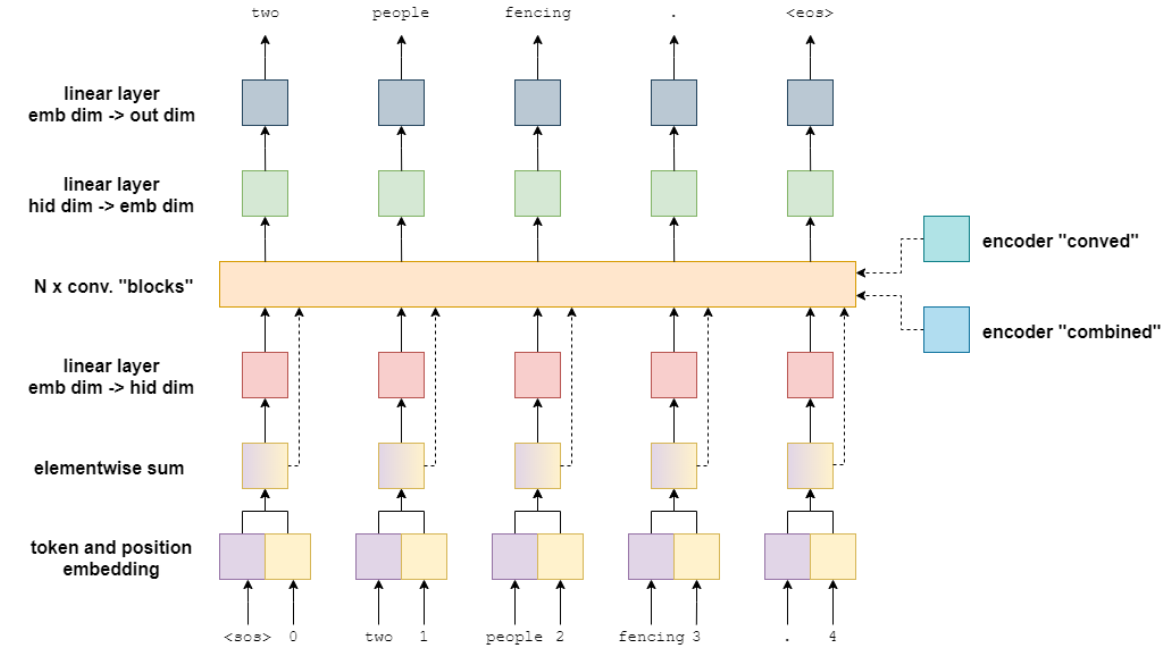

In [15]:
Image(filename = pth + "/images/5_4_decoderCNN.png")

**How `Decoder` Differs from `Encoder`:**

First, the embeddings do not have a residual connection that connects after the convolutional blocks and the transformation. Instead the embeddings are fed into the convolutional blocks to be used as residual connections there.

Second, to feed the `Decoder` information from the `Encoder`, the `Encoder`'s `conved` and `combined` outputs are used - again, within the convolutional blocks.

Finally, the output of the `Decoder` is a linear layer from embedding dimension to output dimension. This is used make a prediction about what the next word in the translation should be.


### `Decoder` Convolutional Blocks

Again, these are similar to the convolutional blocks within the `Encoder`, with a few changes.

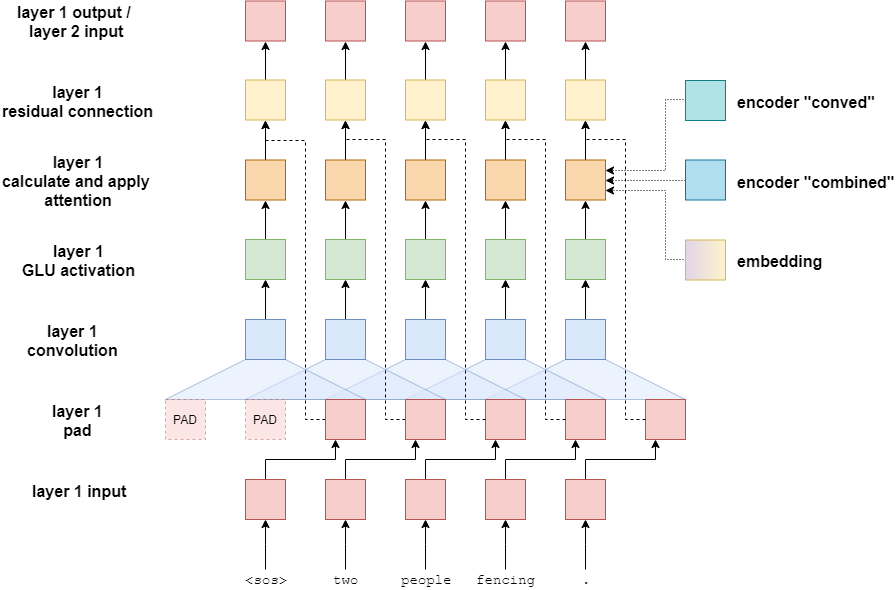

In [16]:
Image(filename = pth + "/images/5_5_decoderCNNBlocks.png")

### [Mechanism of Decoder Convolutional Blocks:](https://hyp.is/2ioPmBUWEeqb9p8tN4Mg-Q/arxiv.org/pdf/1705.03122.pdf)  `convolutionBlock()`

1. **Padding:** First, the padding. Instead of padding equally on each side to ensure the length of the sentence stays the same throughout, we only pad at the beginning of the sentence. 
As we are processing all of the targets simultaneously in parallel, and not sequentially, we need a method of only allowing the filters translating token $i$ to only look at tokens before word $i$. 
If they were allowed to look at token $i+1$ (the token they should be outputting), the model will simply learn to output the next word in the sequence by directly copying it, without actually learning how to translate.

Let's see what happens if we **incorrectly** padded equally on each side, like we do in the `Decoder`.

In [ ]:
Image(filename = pth + "/images/5_6_cnn_pad.png")

The filter at the first position, which is trying use the first word in the sequence, `<sos>` to predict the second word, `two`, can now directly see the word `two`. This is the same for every position, the word the model trying to predict is the second element covered by the filter. 
Thus, the filters can learn to **simply copy the second word** at each position allowing for perfect translation **without actually learning how to translate.**

2. **Apply Convolutional Layer:** We apply the convolutional layer (`self.convolutionLayer`) in the current convolution block to the padded `convInput` tensor from the above step. 

3. [**GLU Activation:**](https://hyp.is/_6WLnhUHEeqAIB8INDB7Hw/arxiv.org/pdf/1705.03122.pdf) Next, we push the tensor resulting from the convolutional layer calculation through the GLU activation function (`F.glu`). After step 2, the tensor has doubled its hidden dimension size for each token. But after passing through GLU, the `hiddenDim` size gets halved again.

4. [**Attention in Decoder:**](https://hyp.is/kY4Y-hKNEeqKKYNq1os8TA/arxiv.org/pdf/1705.03122.pdf) Second, after the [GLU activation](https://hyp.is/_6WLnhUHEeqAIB8INDB7Hw/arxiv.org/pdf/1705.03122.pdf) and before the [residual connection](https://hyp.is/T6ERuBKNEeq9Q-frzC9Wjw/arxiv.org/pdf/1705.03122.pdf), the block calculates and applies attention in `calculateAttention()` - using the encoded representations and the embedding of the current word. 
	- **Note**: we only show the connections to the rightmost token, but they are actually connected to all tokens - this was done for clarity. Each token input uses their own, and only their own, embedding for their own attention calculation.

5. [**Residual Connection:**](https://hyp.is/T6ERuBKNEeq9Q-frzC9Wjw/arxiv.org/pdf/1705.03122.pdf) The attention calculation yields the combined attention `conved` tensor, now called `attnCombinedConv`. We sum this with the tensor that was pushed through the dropout layer to calculate the residual connection for the `conved` tensor. 







### [Attention Calculation in Decoder:](https://hyp.is/kY4Y-hKNEeqKKYNq1os8TA/arxiv.org/pdf/1705.03122.pdf)  `calculateAttention()`


1. **Project: Hidden $\Rightarrow$ Embed Shape:** First use a <font color=red>(true?) linear layer $W_d^l$ (`self.attnHiddenToEmbedLayer()`) </font> on the `conved` tensor $h_i^l$ to project its `hiddenDim` to `embedDim`, yielding `conved_embedShape`. 

2. [**Combined:**](https://hyp.is/Ebgf_hWjEeqiZItSrixbwQ/arxiv.org/pdf/1705.03122.pdf) Next, combine the current `Decoder` state $h_i^l$ (`conved_embedShape`)  with an embedding of the previous target element $g_i$ (`embedding`) using a residual connection formula. The result is the `combined` tensor, $d_i^l$.
The above two steps are [in this formula](https://hyp.is/Ebgf_hWjEeqiZItSrixbwQ/arxiv.org/pdf/1705.03122.pdf): 
**<font color='red'>TODO: is this true?</font>**
$$
d_i^l = W_d^l h_i^l + b_d^l + g_i
$$

3. [**Energy:**](https://hyp.is/50jqchWjEeq_7TOTuDCh9Q/arxiv.org/pdf/1705.03122.pdf) for `Decoder` layer $l$ the attention $a_{ij}^l$ of the state $i$ and source element $j$ is computed as a dot product between the `Decoder` state summary $d_i^l$ and each output $z_u^j$ of the last `Encoder` convolutional block, $u$: 
$$
e_{ij} = d_i^l \cdot z_j^u
$$

Here we are finding out how much the `combined` $d_i^l$ matches the `encoderConv` $z_j^u$.

4. [**Attention:**](https://hyp.is/7MpyQBWjEeqIw7diaHfg-w/arxiv.org/pdf/1705.03122.pdf) Then, for `Decoder` layer $l$ the attention $a_{ij}^l$ of the state $i$ and source element $j$ is computed as softmax of the `energy`: 
$$
a_{ij}^l = \frac {exp(e_{ij})} {\sum_{t=1}^m eexp(e_{it})}
$$

5. [**Weighted Sum:**](https://hyp.is/1uvBfBKNEeqMOz-_A3TvAw/arxiv.org/pdf/1705.03122.pdf) We calculate the `attentionEncoding` $c_i^l$ by finding out how much the `attentionAfterSoftmax` $a_{ij}$ calculation matches the `encoderCombined` $e_j$.

6. **Project: Embed $\Rightarrow$ Hidden Shape:** then use a linear layer `self.attnEmbedToHiddenLayer()` on the `attentionEncoding` tensor $c_i^l$ to project its `embedDim` to `hiddenDim`, yielding `conved_embedShape`. 
This combination then has the standard attention calculation applied by finding how much it "matches" with the `encoderConved` and then this is applied by getting a weighted sum over the `encoderCombined`. This is then projected back up to the `hiddenDim` size and a [residual connection to the initial `convInput` to the attention layer is applied](https://hyp.is/T6ERuBKNEeq9Q-frzC9Wjw/arxiv.org/pdf/1705.03122.pdf).

7. **Residual Connnection for attention:** Apply a residual connection to the initial input `conved` and the reshaped `attentionEncodings`. 
<font color='red'>**TODO True?: The paper writes **steps 5 - 7** in the formula: </font>
$$
c_i^l = \sum_{j=1}^m a_{ij}^l (z_j^u + e_j)
$$
where $c_i^l$ is the conditional input to the current decoder layer $l$, $z_j^u$ = `encoderConved` (the encoder outputs), and $e_j$ = input element embeddings, and $z_j^u + e_j$ = `encoderCombined`. 


[**Explanation of Formula:**](https://hyp.is/-ap_FBKNEeqeKE9HPvw19A/arxiv.org/pdf/1705.03122.pdf) 
Why do they calculate attention first with the `encoderConved`, $z_j^u$, and then use it to calculate the weighted sum over `encoderCombined`?

The paper argues that the `encoderConved` $z_j^u$ is good for getting a larger (input) context over the encoded sequence, whereas $e_j$ provides point information about a specific token (a specific input element) and is thus therefore more useful for makng a prediction.

Once <font color='red'>`attentionEncodings` $c_i^l$ (called *conditional input* in the paper) </font> has been computed (step 4) and reshaped (step 5) it is added to the output of the corresponding decoder layer $h_i^l$ `conved` during the residual connection calculation (step 6). 

This can be seen as attention with multiple "hops", compared to single-step attention. 

The attention of the first layer determines a useful source context which is then fed into the second layer that processes this information while computing attention.

The `Decoder` also has immediate access to the attention history of the $k - 1$ previous time steps because the conditional inputs $c_{i-k}^{l-1}, ..., c_i^{l-1}$ are part of the `Decoder` <font color='red'>`conved` states: $h_{i-k}^{l-1}, ..., h_i^{l-1}$ </font> which are input to $h_i^l$. 

This allows the model to take into account which previous inputs have been attended to already compared to RNNs where this information is in the recurrent state and needs to survive several non-linearities. 



### `Decoder` CNN Forward Pass

As we only pad on one side the `Decoder` is allowed to use both odd and even sized padding. Again, the `scale` is used in the residual connection calculation to reduce variance throughout the model and the position embedding is initialized to have a "vocabulary" of 100.

This model takes in the `Encoder` representations in its `forward` method and both are passed to the `calculateAttention` method which calculates and applies attention. It also returns the actual attention values, but we are not currently using them.

1. Embed the `pos` and `trg` tensors to get their embeddings
2. Apply dropout to the sum of the embedding tensors
3. Reshape the above result by get embed $\Rightarrow$ hidden dimension size. 
4. Apply the convolutional block calculations, where we calculate attention scores. 
5. Pass the tensor result through dropout and the output layer. 

In [18]:
class Decoder(nn.Module):

    def __init__(self, outputDim: int, 
                 embedDim: int, 
                 hiddenDim: int,
                 numLayers: int, 
                 filterSize: int, # kernel size 
                 dropout: float, 
                 trgPadIndex, device):

        super().__init__()

        self.filterSize: int = filterSize
        self.trgPadIndex = trgPadIndex
        self.device = device

        self.scale: Tensor = torch.sqrt(torch.FloatTensor([0.5])).to(device)

        # The standard layer for turning tokens into numbers
        self.tokenEmbeddingLayer = nn.Embedding(num_embeddings=outputDim,
                                                embedding_dim=embedDim)
        # Positional embedding: since there are not recurrent connections in this model,
        # the model doesn't know about order of tokens within a sequence sentence. 
        # So we use positional embeddings: inputs to this layer are the position 
        # of a token within a sequence. 
        # So for instance the <sos> token is in position 0. 
        self.posEmbeddingLayer = nn.Embedding(num_embeddings=100,
                                              embedding_dim=embedDim)

        # 
        self.embedToHiddenLayer = nn.Linear(in_features=embedDim,
                                            out_features=hiddenDim)

        self.hiddenToEmbedLayer = nn.Linear(in_features=hiddenDim,
                                            out_features=embedDim)


        # Attentions
        self.attnForHiddenToEmbedLayer = nn.Linear(in_features=hiddenDim, 
                                                   out_features=embedDim)
        
        self.attnForEmbedToHiddenLayer = nn.Linear(in_features=embedDim, 
                                                   out_features=hiddenDim)
        
        # output layer (?)
        self.outputLayer = nn.Linear(in_features=embedDim, out_features=outputDim)
        
        
        # List of 1-dim convolutional layers

        #   1. input sentence is padded (since convolutional layers will reduce the length
        #       of the input sentence and we want the sentence length that come comes
        #       into the convolutional blcosk TO EQUAL THE LENGTH OF IT coming out
        #       of the convolutional blocks. Without padding, sentence length coming
        #       out of convolutional layer will be `filterSize - 1` shorter than
        #       the sequence entering the convolutional layer.

        #   NOTE: Filters are made so their output hidden dimension = 2 * hiddenDim
        #       (Channels == output hidden dims). Doubling size since we use GLU
        #       (gated linear units) as activation function, which having gating
        #       mechanisms (like LSTM / GRU) inside the activation function and use
        #       half the size of the hiddenDim, whereas usual activiation functions
        #       keep the hiddenDim the same size. 
        self.convolutionLayers = nn.ModuleList([nn.Conv1d(in_channels=hiddenDim,
                                                          out_channels= 2 * hiddenDim,
                                                          kernel_size= filterSize)
                                                          #padding =(filterSize - 1) // 2)
                                                for _ in range(numLayers)])
        ## NOTE: see no more padding on each side here. 
        
        
        self.dropout = nn.Dropout(dropout)






    def calculateAttention(self, embedding: Tensor,
                           conved: Tensor,
                           encoderConved: Tensor, encoderCombined: Tensor) -> (Tensor, Tensor):
        """
        Calculates attention within decoder layer, which is within decoder block
        :param self: 
        :param embedding:
            shape = (batchSize, trgSentenceLen, embedDim) 
        :param conved: 
            shape = (batchSize, hiddenDim, trgSentenceLen)
        :param encoderConved: 
            shape = (batchSize, srcSentenceLen, embedDim)
        :param encoderCombined: 
            shape = (batchSize, srcSentenceLen, embedDim)
            
        :return: 
            attentionAfterSoftmax:
                shape = (batchSize, trgSentenceLen, srcSentenceLen)
            attentionCombined: 
                shape = (batchSize, hiddenDim, trgSentenceLen)
        """

        # Permute and convert back to embed dim
        conved_embedShape: Tensor = self.attnForHiddenToEmbedLayer(conved.permute(0, 2,1))
        ## shape = (batchSize, trgSentenceLen, embedDim)

        # Create the combined vector
        # HERE: combining current decoder stated (conved) with target embedding: 
        ### HYP.IS https://hyp.is/Ebgf_hWjEeqiZItSrixbwQ/arxiv.org/pdf/1705.03122.pdf
        combined:Tensor = (conved_embedShape + embedding) * self.scale
        ## combined shape = (batchSize, trgSentenceLen, embedDim)

        # Energy: dot product between decoder state summary d_i^l and each output
        # z_j^u of the last encoder block (encoderConved)
        # Intuition: finding out how the combination matches with the encoderConved
        #### https://hyp.is/50jqchWjEeq_7TOTuDCh9Q/arxiv.org/pdf/1705.03122.pdf
        # (b, t, e) * (b, e, s) ==> (b, t, s)
        energy: Tensor = torch.matmul(combined, encoderConved.permute(0, 2,1))
        ## energy shape = (batchSize, trgSentenceLen, srcSentenceLen)

        # Attention
        ### https://hyp.is/7MpyQBWjEeqIw7diaHfg-w/arxiv.org/pdf/1705.03122.pdf
        attentionAfterSoftmax: Tensor = F.softmax(input = energy, dim = 2)
        ## attention shape = (batchSize, trgSentenceLen, srcSentenceLen)


        # Result of weighted sum: (why does code stagger it while in formula they write
        # encoderCombined (e_j) and encoderConved (z_u) together?)
        #### https://hyp.is/1uvBfBKNEeqMOz-_A3TvAw/arxiv.org/pdf/1705.03122.pdf
        # (b, t, s) * (b, s, e) ==> (b, t, e)
        # Intuition: finding out how much attention matches encoderCombined by 
        # getting weighted sum. 
        attentionEncoding: Tensor = torch.matmul(attentionAfterSoftmax, encoderCombined)
        ## shape = (batchSize, trgSentenceLen ,embedDim)

        # Convert back from embedDim => hiddenDim (projecting to hiddenDim size)
        attentionEncoding_hiddenShape: Tensor = \
            self.attnForEmbedToHiddenLayer(attentionEncoding)
        ## shape = (batchSize, trgSentenceLen, hiddenDim)

        # Apply residual connection to initial input and attention layer.
        ### https://hyp.is/T6ERuBKNEeq9Q-frzC9Wjw/arxiv.org/pdf/1705.03122.pdf
        attentionCombined: Tensor = (conved +
                                     attentionEncoding_hiddenShape.permute(0, 2,1)) * self.scale
        ## shape = (batchSize, hiddenDim, trgSentenceLen)


        return attentionAfterSoftmax, attentionCombined




    def convolutionBlock(self, convLayer, 
                         convInput: Tensor, 
                         embedding: Tensor,
                         encoderConved: Tensor, 
                         encoderCombined: Tensor) -> (Tensor, Tensor):
        """
        Pass the convInput through the given convLayer
        
        :param self: 
        :param convLayer: 
        :param convInput:
            shape = (batchSize, hiddenDim, trgSentenceLen)
        :param embedding:
            shape = (batchSize, trgSentenceLen, embedDim)
        :param encoderConved:
            shape = (batchSize, srcSentenceLen, embedDim)
        :param encoderCombined:
            shape = (batchSize, srcSentenceLen, embedDim)
        
        :return: 
        """
        # Apply dropout
        convAfterDropout: Tensor = self.dropout(convInput)
        
        # Pad so that decoder cannot copy-cheat
        batchSize, hiddenDim, _ = convInput.shape 
        padding: Tensor = torch.zeros(batchSize, 
                                      hiddenDim, 
                                      self.filterSize - 1)\
            .fill_(self.trgPadIndex)\
            .to(self.device)
        # shape = (batchSize, hiddenDim, filterSize - 1)
        
        convAfterPadding: Tensor = torch.cat((padding, convAfterDropout), dim = 2)
        # paddedconvinput shape = (batchSize, hiddenDim, trgSentLen + filterSize - 1)
        
        
        # Pass through convolutional layer: 
        # (SEE description above of the convolutional layers' transformations)
        convAfterLayer: Tensor = convLayer(convAfterPadding)
        ## shape = (batchSize, 2 * hiddenDim, trgSentenceLen)

        # Pass through GLU activation function
        convAfterGLU: Tensor = F.glu(input = convAfterLayer, dim = 1)
        ## shape = (batchSize, hiddenDim, trgSentenceLen)
        ## NOTE: After passing through the GLU activation the hidden dimension size 
        # for each token is the same as it was when it entered the convolutional 
        # blocks. (thanks to out_channels = 2 * hiddenDIm to account for GLU's halving
        # of the hiddenDim)
        
        
        # Calculate attention
        attnAfterSoftmax, attnCombinedConv = self.calculateAttention(embedding = embedding, 
                                                    conved = convAfterGLU,
                                                    encoderConved = encoderConved,
                                                    encoderCombined = encoderCombined)
        # attention shape = (batchSize, trgSentenceLen, srcSentenceLen)
        

        ## Apply the residual connection
        convAfterResidConn: Tensor = (attnCombinedConv + convAfterDropout) * self.scale
        ## shape = (batchSize, hiddenDim, trgSentenceLen)

        # set convInput to conved for the next loop iteration
        #convInput: Tensor = conved
        return attnAfterSoftmax, convAfterResidConn




    def runConvolutionBlocks(self, startingConvInput: Tensor,
                             embedding: Tensor,
                             encoderConved: Tensor,
                             encoderCombined: Tensor) -> (Tensor, Tensor):
        """
        Pass the given convInput vector through all the conv blocks using the
        layers in the Encoder. 
        Subsequent blocks take output of previous block and perform the same steps.
        Each block has its own convLayer, which is not shared between blocks. 
        The output of the last blcok goes back to the main encoder's forward function
        for more processing. 
        
        :param startingConvInput: 
            shape = (batchSize, hiddenDim, trgSentenceLen)
        :param embedding: 
            shape = (batchSize, trgSentenceLen, embedDim)
        :param encoderConved: 
            shape = (batchSize, srcSentenceLen, embedDim)
        :param encoderCombined: 
            shape = (batchSize, srcSentenceLen, embedDim)
            
        :return: 
        """
        # Assign here so we can do the for loop
        nextConvInput: Tensor = startingConvInput
        attention: Tensor = torch.zeros([]) # placeholder

        for i, nextConvLayer in enumerate(self.convolutionLayers):

            attention, nextConvInput = self.convolutionBlock(convLayer = nextConvLayer,
                                                          convInput = nextConvInput, 
                                                          embedding = embedding,
                                                          encoderConved = encoderConved,
                                                          encoderCombined = encoderCombined)

        ## nextconvinput shape = (batchSize, hiddenDim, srcSentenceLen)
        # attention shape = (batchSize, trgSentenceLen, srcSentenceLen)
        return attention, nextConvInput # need last attention only





    def forward(self, trg:Tensor, encoderConved: Tensor, encoderCombined: Tensor):
        """
        
        :param trg: 
            shape = (batchSize, trgSentenceLen)
        :param encoderConved: 
            shape = (batchSize, srcSentenceLen, embedDim)
        :param encoderCombined: 
            shape = (batchSize, srcSentenceLen, embedDim)
            
        :return: 
        """
        batchSize, trgSentenceLen = trg.shape

        # Create position tensor
        pos: Tensor = torch.arange(0, trgSentenceLen) \
            .unsqueeze(0) \
            .repeat(batchSize, 1) \
            .to(self.device)
        # pos shape = (batchSize, trgSentenceLen)
        
        
        # Embed the tokens and positions
        tokenEmbedding: Tensor = self.tokenEmbeddingLayer(trg)
        posEmbedding: Tensor = self.posEmbeddingLayer(pos) 
        ## token shape = (batchSize, trgSentenceLen, embedDim)
        ## pos shape = (batchSize, trgSentenceLen, embedDim)


        # Combine embeddings by elementwise summing
        totalEmbedding: Tensor = self.dropout(tokenEmbedding + posEmbedding)
        ##shape = (batchSize, trgSentenceLen, embedDim)

        # Pass embeddings through linear layer to go through embedDim => hiddenDim
        convInput_hiddenShape: Tensor = self.embedToHiddenLayer(totalEmbedding)
        # shape = (batchSize, trgSentenceLen, hiddenDim)

        # Permute for convolutional layer
        convInput_hiddenShape: Tensor = convInput_hiddenShape.permute(0, 2, 1)
        ## shape = (batchSize, hiddenDim, trgSentenceLen)



        ## Begin convolutional blocks for decoder .................................

        attention, conved = self.runConvolutionBlocks(startingConvInput= convInput_hiddenShape, 
                                                   embedding = totalEmbedding, 
                                                   encoderConved = encoderConved,
                                                   encoderCombined = encoderCombined)
        ## nextconvinput shape = (batchSize, hiddenDim, srcSentenceLen)
        # attention shape = (batchSize, trgSentenceLen, srcSentenceLen)

        ## End convolutional blocks ...............................................


        # Pemute and convert back from hiddenDim => embedDim
        conved_embedShape: Tensor = self.hiddenToEmbedLayer(conved.permute(0, 2, 1))
        ## shape = (batchSize, trgSentenceLen, embedDim)


        # output
        output: Tensor = self.outputLayer(self.dropout(conved_embedShape))
        
        # output shape = (batchSize, trgSentenceLen, outputDim)
        # # attention shape = (batchSize, trgSentenceLen, srcSentenceLen)
        return output, attention 
    

### Seq2Seq

The encapsulating `Seq2Seq` module is a lot different from recurrent neural network methods used in previous notebooks, especially in the decoding.

**Differences in `Decoder`:**

1. The `trg` has the `<eos>` element sliced off of the end of the sequence. This is because we do not input the `<eos>` token into the `Decoder`.

2. As the decoding is done in parallel we do not need a decoding loop. All of the target sequence is input into the `Decoder` at once and the padding is used to ensure each convolutional filter in the `Decoder` can only see the current and previous tokens in the sequence as it slides across the sentence.

3. This also, however, means we cannot do teacher forcing using this model. We do not have a loop in which we can choose whether to input the predicted token or the actual token in the sequence as everything is predicted in parallel.


**Differences in `Encoder`:**

The encoding is similar, insert the source sequence and receive a "context vector". However, here we have two context vectors per word in the source sequence, `encoderConved` and `encoderCombined`.

In [19]:
class Seq2Seq(nn.Module):
    
    
    def __init__(self, encoder: Encoder, decoder: Decoder):
        
        super().__init__()
        
        self.encoder: Encoder = encoder
        self.decoder: Decoder = decoder
        
        
        
    def forward(self, src: Tensor, trg: Tensor) -> (Tensor, Tensor):
        """
        
        :param src:
            shape = (batchSize, srcSentenceLen) 
        :param trg: 
            shape = (batchSize, trgSentenceLen - 1) (since <eos> token is sliced off the end)
        :return: 
        """
        
        # Calculate z^u (encoderConved) and (z^u + e) (encoderCombined)
        # Encoder-conved = output from the final encoder convolution block
        # ENcoder-combined = encoderConved + (elementwise) srcEmbedding + posEmbeddings
        encoderConved, encoderCombined = self.encoder(src = src)
        ## encoderConved shape = (batchSize, srcSentenceLen, embedDim)
        ## encoderCombined shape = (batchSize, srcSentenceLen, embedDim)
        
        # Calculate predictions of next words
        # output = batch of predictions for each word in the trg sentence
        # attention = batch of attention scores across the src sentence for each word in 
        # the trg sentence
        output, attention = self.decoder(trg = trg, 
                                         encoderConved = encoderConved, 
                                         encoderCombined = encoderCombined)
        ## output shape = (batchSize, trgSentenceLen - 1, outputDim)
        ## attention shape = (batchSize, trgSentenceLen - 1, srcSentenceLen)
        
        return output, attention 
        

## Training the Seq2Seq Model


### Step 1: Initialize the Seq2Seq CNN Model 

The rest of the tutorial is similar to all of the previous ones. We define all of the hyperparameters, initialize the `Encoder` and `Decoder`, and initialize the overall model - placing it on the GPU if we have one.

In the paper they find that it is more beneficial to use a small filter (kernel size of 3) and a high number of layers (5+).

In [20]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
NUM_ENC_CONV_LAYERS = 10 # number of conv. blocks in encoder
NUM_DEC_CONV_LAYERS = 10 # number of conv. blocks in decoder
ENC_FILTER_SIZE = 3 # must be odd!
DEC_FILTER_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

enc = Encoder(inputDim = INPUT_DIM, embedDim= EMB_DIM, hiddenDim = HID_DIM,
              numLayers=NUM_ENC_CONV_LAYERS, filterSize= ENC_FILTER_SIZE,
              dropout = ENC_DROPOUT, device = device)

dec = Decoder(outputDim = OUTPUT_DIM, embedDim= EMB_DIM, hiddenDim = HID_DIM,
              numLayers=NUM_DEC_CONV_LAYERS, filterSize= DEC_FILTER_SIZE,
              dropout = DEC_DROPOUT, trgPadIndex= TRG_PAD_IDX, device = device)

seqCNNModel = Seq2Seq(encoder = enc, decoder = dec).to(device)

In [21]:
enc

Encoder(
  (tokenEmbeddingLayer): Embedding(7853, 256)
  (posEmbeddingLayer): Embedding(100, 256)
  (embedToHiddenLayer): Linear(in_features=256, out_features=512, bias=True)
  (hiddenToEmbedLayer): Linear(in_features=512, out_features=256, bias=True)
  (convolutionLayers): ModuleList(
    (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (8): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding

In [45]:
dec

Decoder(
  (tokenEmbeddingLayer): Embedding(5893, 256)
  (posEmbeddingLayer): Embedding(100, 256)
  (embedToHiddenLayer): Linear(in_features=256, out_features=512, bias=True)
  (hiddenToEmbedLayer): Linear(in_features=512, out_features=256, bias=True)
  (attnForHiddenToEmbedLayer): Linear(in_features=512, out_features=256, bias=True)
  (attnForEmbedToHiddenLayer): Linear(in_features=256, out_features=512, bias=True)
  (outputLayer): Linear(in_features=256, out_features=5893, bias=True)
  (convolutionLayers): ModuleList(
    (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
    (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
    (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
    (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
    (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
    (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
    (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
    (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
    (8): C

In [22]:
seqCNNModel

Seq2Seq(
  (encoder): Encoder(
    (tokenEmbeddingLayer): Embedding(7853, 256)
    (posEmbeddingLayer): Embedding(100, 256)
    (embedToHiddenLayer): Linear(in_features=256, out_features=512, bias=True)
    (hiddenToEmbedLayer): Linear(in_features=512, out_features=256, bias=True)
    (convolutionLayers): ModuleList(
      (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (8): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (9): Conv

In [23]:
device

device(type='cpu')

### Step 2: Count Parameters

We can also see that the model has almost twice as many parameters as the attention based model (20m to 37m).

In [24]:
def countParameters(model: Seq2Seq):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {countParameters(seqCNNModel):,} trainable parameters')

The model has 37,351,173 trainable parameters


### Step 3: Define Optimizer

In [25]:
adamOptimizer = optim.Adam(seqCNNModel.parameters())
adamOptimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

### Step 4: Define the Loss Function (Cross Entropy)
Make sure to ignore the loss on <pad> tokens.

In [26]:
TRG_PAD_IDX

1

In [27]:
crossEntropyLossFunction = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
crossEntropyLossFunction

CrossEntropyLoss()

### Step 5: Define Training Loop

Then, we define the training loop for the model.

We handle the sequences a little differently than previous tutorials. For all models we never put the `<eos>` into the `Decoder`. This is handled in the RNN models by the having the `Decoder` loop not reach having the `<eos>` as an input to the `Decoder`. But in this CNN model, we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos] \\
    \text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$
where $x_i$ = the actual target sequence element. 

We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$
where $y_i$ = the predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\ \
    \text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [28]:
def train(seqModel: Seq2Seq, iterator, optimizer, lossFunction, clip: int):

    seqModel.train() # put model in training mode

    lossPerEpoch: int = 0

    for epoch, batch in enumerate(iterator):

        # 1. Getting source and target sentences from batch
        srcSentence: Tensor = batch.src
        trgSentence: Tensor = batch.trg

        # 2. Zero the gradients from the last batch
        optimizer.zero_grad()

        # 3. Feed the source and target sentences into the seq2seq model
        # to get the output tensor of predictions.
        output, _ = seqModel(src = srcSentence, trg = trgSentence[:, :-1])
        ### trgSentence = tensor of shape (batchSize, trgSentenceLen)
        ### output = tensor of shape (batchSize, trgSentenceLen - 1, outputDim)

        # 4. Need to flatten the outputs (by slicing off the first column 
        # of the output and target tensors
        # as mentioned above)
        outputDim: int = output.shape[-1]

        output: Tensor = output.contiguous().view(-1, outputDim)
            #output[1:].view(-1, outputDim)
        trgSentence: Tensor = trgSentence[:, 1:].contiguous().view(-1)
            #trgSentence[1:].view(-1)
        ## output shape now: (batchSize * trgLen - 1, outputDim)
        ## trgSentence shape now: (batchSize * trgLen - 1)

        # 5. Calculate gradients
        loss = lossFunction(input=output, target= trgSentence)
        loss.backward()

        # 6. Clip gradient so it doesn't explode
        torch.nn.utils.clip_grad_norm_(parameters = seqModel.parameters(),
                                       max_norm = clip)

        # 7. Update parameters of model
        optimizer.step()

        # 8. Sum the loss value to a running total
        lossPerEpoch += loss.item()

    return lossPerEpoch / len(iterator) # average loss

### Step 7: Define Evaluation Loop

The evaluation loop is the same as the training loop, just without the gradient calculations and parameter updates.

In [29]:
def evaluate(seqModel: Seq2Seq, iterator, lossFunction):

    seqModel.eval()

    lossPerEpoch = 0

    with torch.no_grad():

        for epoch, batch in enumerate(iterator):

            srcSentence: Tensor = batch.src
            trgSentence: Tensor = batch.trg

            # Turn off teacher forcing
            output, _ = seqModel(src=srcSentence, trg=trgSentence[:, :-1])
            ### trgSentence = tensor of shape (batchSize, trgSentenceLen)
            ### output = tensor of shape (batchSize, trgSentenceLen - 1, outputDim)
    
            # 4. Need to flatten the outputs (by slicing off the first column 
            # of the output and target tensors
            # as mentioned above)
            outputDim: int = output.shape[-1]
    
            output: Tensor = output.contiguous().view(-1, outputDim)
            #output[1:].view(-1, outputDim)
            trgSentence: Tensor = trgSentence[:, 1:].contiguous().view(-1)
            #trgSentence[1:].view(-1)
            ## output shape now: (batchSize * trgLen - 1, outputDim)
            ## trgSentence shape now: (batchSize * trgLen - 1)
    
            # 5. Calculate loss but not gradients since this is evaluation mode
            loss = lossFunction(input=output, target= trgSentence)
    
    
            # 6. Sum the loss value to a running total
            lossPerEpoch += loss.item()
    
        return lossPerEpoch / len(iterator) # average loss

In [30]:
# Time the epoch!

def epochTimer(startTime, endTime):
    elapsedTime = endTime - startTime
    elapsedMins = int(elapsedTime / 60)
    elapsedSecs = int(elapsedTime - (elapsedMins * 60))
    return elapsedMins, elapsedSecs

### Step 8: Train the Model

Finally, we train our model.

Although we have almost twice as many parameters as the attention based RNN model, it actually takes around half the time as the standard version and about the same time as the packed padded sequences version. This is due to all calculations being done in parallel using the convolutional filters instead of sequentially using RNNs. 

**Note**: this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence. This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. See [here](https://github.com/bentrevett/pytorch-seq2seq/issues/39#issuecomment-529408483) for the results of the attention based RNN using a teacher forcing ratio of 1. 

In [31]:
%%time

NUM_EPOCHS = 10
CLIP = 1

bestValidLoss = float('inf')

for epoch in range(NUM_EPOCHS):

    startTime = time.time()

    trainingLoss = train(seqModel=seqCNNModel,
                         iterator=trainIterator,
                         optimizer=adamOptimizer,
                         lossFunction=crossEntropyLossFunction,
                         clip=CLIP)

    validationLoss = evaluate(seqModel=seqCNNModel,
                              iterator=validationIterator,
                              lossFunction=crossEntropyLossFunction)

    endTime = time.time()

    epochMins, epochSecs = epochTimer(startTime , endTime)

    if validationLoss < bestValidLoss:
        bestValidLoss = validationLoss
        torch.save(seqCNNModel.state_dict(), 'tut5_bestModel.pt')


    print(f'Epoch: {epoch+1:02} | Time: {epochMins}m {epochSecs}s')
    print(f'\tTrain Loss: {trainingLoss:.3f} | Train PPL: {math.exp(trainingLoss):7.3f}')
    print(f'\t Val. Loss: {validationLoss:.3f} |  Val. PPL: {math.exp(validationLoss):7.3f}')

In [ ]:
# We'll load the parameters (state_dict) that gave our model the best 
# validation loss and run it the model on the test set.

seqCNNModel.load_state_dict(torch.load('tut4_bestModel.pt'))

testLoss = evaluate(seqModel=seqCNNModel,
                    iterator= testIterator,
                    lossFunction= crossEntropyLossFunction)

# show test loss and calculate test perplexity score: 
print(f'| Test Loss: {testLoss:.3f} | Test PPL: {math.exp(testLoss):7.3f} |')

## Inference

Now we can use our trained model to generate translations.

Our `translateSentence` will do the following:

1. Ensure our model is in evaluation mode, which it should always be for inference
    2. Tokenize the source sentence if it has not been tokenized (is a string)
3. Append the `<sos>` and `<eos>` tokens.
4. Numericalize the source sentence
5. Convert the source sentence it to a tensor and add a batch dimension
6. Feed the source sentence into the `Encoder`
7. Create a list to hold the output sentence, initialized with an `<sos>` token
8. While we have not hit a maximum length
a) Convert the current output sentence prediction into a tensor with a batch dimension.
b) Feed the current output, and two `Encoder` outputs into the `Decoder`
c) Get the predicted next token from `Decoder`
d) Add prediction to current output sentence prediction
e) Break if the prediction was an `<eos>` token
9. Convert the output sentence from indexes to tokens
10. Return the output sentence (with the `<sos>` token removed) and the attention from the last layer. 

In [ ]:
def translateSentence(sentence, srcField: Field, trgField: Field,
                      seqModel: Seq2Seq,
                      device, maxLen: int = 50) -> (Tensor, Tensor):

    # 1. Put model in evaluation mode as it should be before inference
    seqModel.eval()


    # 2. Tokenize source sentence
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        # make them lowercase
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]


    # 3. Append the <sos> and <eos> tokens
    tokens = [srcField.init_token] + tokens + [srcField.eos_token]

    # 4. Numericalize the source sentence
    srcIndices = [srcField.vocab.stoi[token] for token in tokens]

    # 5. Convert the numericalized source sentence into a tensor and add a batch
    # dimension at dim = 0 (why here dim = 0 while before it was at dim = 1?)
    srcSentenceTensor: Tensor = torch.LongTensor(srcIndices).unsqueeze(0).to(device)

    # 6. Feed the source sentence into the encoder
    #### NOTE: torch.no_grad() impacts the autograd engine and deactivate it. 
    # It will reduce memory usage and speed up computations but you won't be able 
    # to backprop (no need to backprop in an eval script).
    with torch.no_grad():
        encoderConved, encoderCombined = seqModel.encoder(src = srcSentenceTensor)

    # 7. Create a list to hold the output sentence, initialized with an `<sos>` token
    trgIndices = [trgField.vocab.stoi[trgField.init_token]]


    # 8. While we have not hit a maximum length
    for i in range(maxLen):
        #   a) Convert the current output sentence prediction into a tensor
        # with a batch dimension
        trgInputTensor: Tensor = torch.LongTensor(trgIndices).unsqueeze(0).to(device)

        #   b) Feed the current output and two encoder inputs into the decoder.
        with torch.no_grad():
            output, attention = seqModel.decoder(trg = trgInputTensor,
                                                 encoderConved = encoderConved,
                                                 encoderCombined = encoderCombined)


        #   c) Get the predicted next token from decoder
        nextPredToken = output.argmax(2)[:, -1].item()

        #   d) Add prediction to current output sentence prediction
        trgIndices.append(nextPredToken)

        #   e) Break if the prediction was an `<eos>` token
        if nextPredToken == trgField.vocab.stoi[trgField.eos_token]:
            break

            # 9. Convert the output sentence from indexes to tokens
    trgTokens = [trgField.vocab.itos[i] for i in trgIndices]

    # 10. Return the output sentence (with the `<sos>` token removed) and the 
    # attention values over the sequence
    return trgTokens[1:], attention
    

In [ ]:
## Create function to display how much the model pays 
# attention to each input token during each step of the decoding

def displayAttention(sentence, translation, attention):
    """
    
    :param sentence: 
    :param translation: 
    :param attention: 
    :return: 
    """
    """
    fig, ax = plt.subplots()
    
    # convert attention to numpy array
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap = 'bone')

    ax.tick_params(labelsize=15)
    ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'],
                       rotation=45)
    ax.set_yticklabels([''] + translation)
 
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    cax
    plt.show()
    """
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(0).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

### Train Data Example Translation

Then we'll finally start translating some sentences. **Note**: these sentences have been cherry picked.

First, we'll get an example from the training set:

In [ ]:
exampleIndex = 12

src = vars(trainData.examples[exampleIndex])['src']
trg = vars(trainData.examples[exampleIndex])['trg']

print(f'src = {src}')
print(f'trg = {trg}')


translation, attn = translateSentence(sentence=src,
                                      srcField = SRC, trgField = TRG,
                                      seqModel = seqCNNModel,
                                      device=device)

print(f'predicted trg = {translation}')

Then we pass it into our `translateSentence` function which gives us the predicted translation tokens as well as the attention.

We can see above that it doesn't give the exact same translation, however it does capture the same meaning as the original. It is actual a more literal translation as *aus holz* literally translates to *of wood*, so a *wooden playhouse* is the same thing as a *playhouse made of wood*.

#### Display Attention (Train data):

Below we view the attention of the model, making sure it gives sensible looking results
We can see it correctly pays attention to *aus* when translating both *made* and *of*.

In [ ]:
displayAttention(sentence = src, translation = translation, attention = attn)

### Validation Set Example Translation:

In [ ]:
exampleIndex = 2

src = vars(validationData.examples[exampleIndex])['src']
trg = vars(validationData.examples[exampleIndex])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

translation, attn = translateSentence(sentence=src,
                                      srcField = SRC, trgField = TRG,
                                      seqModel = seqCNNModel,
                                      device=device)

print(f'predicted trg = {translation}')

The model managed to translate this one perfectly.


### Display Attention (Test data):

Again, we can see the attention is applied to sensible words. 

We can also see the model pays full attention to the period at the end of the sentence when outputting the `<eos>` token. 

The model also seems to only occasionally pay attention to the `<sos>` and `<eos>` tokens from the source sentence. This is potentially because they are at the start and end of every single sentence and therefore contain no actual information about the contents of a sentence.

In [ ]:
displayAttention(sentence = src, translation = translation, attention = attn)

### Test Data Translation Example: 

In [ ]:
exampleIndex = 9

src = vars(validationData.examples[exampleIndex])['src']
trg = vars(validationData.examples[exampleIndex])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

translation, attn = translateSentence(sentence=src,
                                      srcField = SRC, trgField = TRG,
                                      seqModel = seqCNNModel,
                                      device=device)

print(f'predicted trg = {translation}')

We get a generally correct translation here, although the model changed _sitting **in** a chair_ to _sitting **on** a chair_ and removes the *and*.

The word *magazines* is not in our vocabulary, hence it was output as an unknown token.


### Display Attention (Test Data): 

The attention seems to be correct. No attention is payed to *und* as it never outputs *and* and the word *magazine* is correctly attended to even though it is not in the output vocabulary.

In [ ]:
displayAttention(sentence = src, translation = translation, attention = attn)

## BLEU

Finally, we calculate the BLEU score for the model.

**Note:** the BLEU functionality is currently in `bleu.py` but this metric will be officially incorporated into TorchText in the near future. We are using the exact same implementation, found [here](https://github.com/pytorch/text/blob/master/torchtext/data/metrics.py). 

In [ ]:
import bleu

def calculateBleu(data,
                  srcField: Field, trgField: Field,
                  seqModel: Seq2Seq,
                  device, maxLen = 50):

    trgList = []
    predTrgList = []

    for datum in data:

        src = vars(datum)['src']
        trg = vars(datum)['trg']

        predTrg, _ = translateSentence(sentence = src,
                                       srcField = srcField, trgField = trgField,
                                       seqModel = seqModel,
                                       device = device, maxLen = maxLen)
        #cut off <eos> token
        predTrg = predTrg[:-1]

        trgList.append(trg)
        predTrgList.append([predTrg])

    return bleu.bleuScore(trgList, predTrgList)





theBleuScore = calculateBLEU(data = testData, 
                             srcField = SRC, trgField = TRG,
                             seqModel = seqCNNModel,
                             device = device)

print(f'BLEU score = {theBleuScore*100:.2f}')

We get a BLEU score of ~34, compared to the attention based RNN model which gave us a ~29. This is a ~17% improvement in BLEU score.

We've now covered the first of our non-RNN using models! Next up is the `Transformer` model which doesn't even use convolutional layers - only linear layers and a lot of attention mechanisms.